# PROYECTO NLP - PIPELINE COMPLETO
Clasificación de Sentimientos con Análisis Exhaustivo


### Estudiantes
Gustavo Andres Gonzalez Pineda - 21438
Maria Marta Ramirez Gil - 21342

# =============================
# 1. IMPORTACIÓN DE LIBRERÍAS
# =============================

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy
import Levenshtein

# ML Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Word Embeddings
from gensim.models import Word2Vec, FastText

# Visualization
from wordcloud import WordCloud

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Todas las librerías importadas correctamente")

✓ Todas las librerías importadas correctamente


# ============================================================================
# 2. CARGA Y CREACIÓN DEL CORPUS (DATASET EXPANDIDO)
# ============================================================================

In [32]:
print("\n" + "="*80)
print("CREACIÓN DEL CORPUS DE DATOS")
print("="*80)

np.random.seed(42)

# Templates expandidos para generar corpus realista de 3000+ documentos
positivos_templates = [
    "excelente producto calidad precio recomiendo totalmente",
    "muy satisfecho compra superó expectativas",
    "increíble servicio rápido bien empaquetado perfecto",
    "fantástico mejor compra año definitivamente volveré",
    "maravilloso alta calidad vale pena inversión",
    "genial cumple funciones perfectamente satisfecho",
    "buenísimo llegó tiempo perfecto estado recomiendo",
    "espectacular justo buscaba muy contento",
    "magnífico producto premium calidad excepcional",
    "extraordinario supera descripción muy feliz compra",
    "perfecto exactamente esperaba cinco estrellas",
    "impresionante calidad construcción durabilidad excelente",
    "sobresaliente mejor opción mercado sin duda",
    "fabuloso diseño elegante funcional práctico",
    "brillante solución problema perfecto uso diario",
    "estupendo relación calidad precio insuperable",
    "formidable cumple promesas vendedor honesto",
    "sensacional mejor inversión hecho recomiendo ampliamente",
    "increíblemente bueno resistente duradero confiable",
    "tremendamente satisfecho volveré comprar definitivamente"
]

negativos_templates = [
    "pésimo producto no funciona mal hecho",
    "muy mala calidad rompió primer uso decepcionante",
    "no recomiendo pérdida dinero tiempo",
    "terrible experiencia nunca más compraré aquí",
    "decepcionante no cumple promete publicidad engañosa",
    "malo llegó dañado tarde servicio horrible",
    "horrible nada descripción estafa total",
    "deficiente calidad inferior esperado basura",
    "muy insatisfecho compra no sirve propósito",
    "malísimo funciona mal desde inicio defectuoso",
    "pobre construcción materiales baratos frágil",
    "lamentable producto mediocre sobrevalorado caro",
    "inaceptable calidad precio desproporcionado injusto",
    "deplorable servicio atención cliente nulo",
    "fraudulento producto falsificado imitación barata",
    "nefasto peor compra vida arrepentido",
    "desastroso diseño malo incómodo inútil",
    "patético rendimiento bajo expectativas defraudado",
    "abominable producto peligroso inseguro evitar",
    "espantoso calidad construcción endeble rompe fácil"
]

neutros_templates = [
    "producto está bien nada especial cumple",
    "normal cumple función básica esperada",
    "aceptable aunque esperaba algo más completo",
    "está ok tiene cosas buenas malas",
    "ni muy bueno ni malo promedio",
    "cumple descripción sin más destacable",
    "correcto para precio pagado razonable",
    "decente funciona sin problemas particular",
    "adecuado propósito básico nada extraordinario",
    "suficiente cubre necesidades mínimas aceptable",
    "regular calidad estándar mercado promedio",
    "pasable sirve emergencia solución temporal",
    "mediano desempeño esperado gama media",
    "común corriente nada impresionante ordinario",
    "básico funcional simple sin lujos"
]

# Función para generar variaciones
def generar_variaciones(template, n_variaciones=50):
    variaciones = []
    palabras = template.split()
    
    for _ in range(n_variaciones):
        # Mezclar orden (algunos casos)
        if np.random.random() > 0.7:
            np.random.shuffle(palabras)
        
        # Agregar palabras de relleno
        rellenos = ['muy', 'bastante', 'realmente', 'absolutamente', 'totalmente', 
                    'completamente', 'sin duda', 'definitivamente', 'ciertamente']
        if np.random.random() > 0.6:
            palabras_mod = palabras.copy()
            palabras_mod.insert(np.random.randint(0, len(palabras_mod)), np.random.choice(rellenos))
        else:
            palabras_mod = palabras
        
        # Agregar variaciones ortográficas ocasionales
        texto = ' '.join(palabras_mod)
        variaciones.append(texto)
    
    return variaciones

# Generar corpus grande
print("🔄 Generando corpus de 3000+ documentos...")

corpus_positivo = []
for template in positivos_templates:
    corpus_positivo.extend(generar_variaciones(template, 50))

corpus_negativo = []
for template in negativos_templates:
    corpus_negativo.extend(generar_variaciones(template, 50))

corpus_neutro = []
for template in neutros_templates:
    corpus_neutro.extend(generar_variaciones(template, 67))

# Crear DataFrame
textos = corpus_positivo + corpus_negativo + corpus_neutro
etiquetas = (['positivo'] * len(corpus_positivo) + 
             ['negativo'] * len(corpus_negativo) + 
             ['neutro'] * len(corpus_neutro))

df = pd.DataFrame({
    'texto': textos,
    'sentimiento': etiquetas
})

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n📊 CORPUS GENERADO EXITOSAMENTE")
print(f"Total de documentos: {len(df)}")
print(f"\nDistribución de clases:")
print(df['sentimiento'].value_counts())
print(f"\nBalance de clases:")
for sentimiento in df['sentimiento'].unique():
    pct = (df['sentimiento'] == sentimiento).sum() / len(df) * 100
    print(f"  {sentimiento}: {pct:.1f}%")


CREACIÓN DEL CORPUS DE DATOS
🔄 Generando corpus de 3000+ documentos...

📊 CORPUS GENERADO EXITOSAMENTE
Total de documentos: 3005

Distribución de clases:
sentimiento
neutro      1005
positivo    1000
negativo    1000
Name: count, dtype: int64

Balance de clases:
  positivo: 33.3%
  negativo: 33.3%
  neutro: 33.4%


# ============================================================================
# 3. PREPROCESAMIENTO DEL TEXTO
# ============================================================================

In [33]:
print("\n" + "="*80)
print("FASE 1: PREPROCESAMIENTO DEL TEXTO")
print("="*80)

# Cargar recursos
try:
    nlp = spacy.load('es_core_news_sm')
except:
    print("⚠️  Instalando modelo de spaCy...")
    import os
    os.system('python -m spacy download es_core_news_sm')
    nlp = spacy.load('es_core_news_sm')

stemmer = SnowballStemmer('spanish')
stop_words = set(stopwords.words('spanish'))

def preprocesar_texto(texto, usar_stemming=True, usar_lematizacion=False):
    """
    Preprocesa el texto aplicando múltiples técnicas
    """
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Remover caracteres especiales y números
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)
    
    # Tokenización
    tokens = word_tokenize(texto, language='spanish')
    
    # Remover stopwords y tokens muy cortos
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    
    # Stemming
    if usar_stemming:
        tokens = [stemmer.stem(t) for t in tokens]
    
    # Lematización con spaCy (alternativa)
    if usar_lematizacion:
        doc = nlp(' '.join(tokens))
        tokens = [token.lemma_ for token in doc]
    
    return tokens

# Aplicar preprocesamiento
print("\n🔧 Aplicando preprocesamiento...")
df['tokens'] = df['texto'].apply(lambda x: preprocesar_texto(x, usar_stemming=True))
df['texto_procesado'] = df['tokens'].apply(lambda x: ' '.join(x))

print("\n✓ Preprocesamiento completado")
print(f"\nEjemplo de transformación:")
print(f"Original: {df['texto'].iloc[0]}")
print(f"Procesado: {df['texto_procesado'].iloc[0]}")

# Estadísticas del corpus
print(f"\n📊 Estadísticas del corpus:")
print(f"Longitud promedio (tokens): {df['tokens'].apply(len).mean():.1f}")
print(f"Longitud máxima: {df['tokens'].apply(len).max()}")
print(f"Longitud mínima: {df['tokens'].apply(len).min()}")


FASE 1: PREPROCESAMIENTO DEL TEXTO

🔧 Aplicando preprocesamiento...

🔧 Aplicando preprocesamiento...

✓ Preprocesamiento completado

Ejemplo de transformación:
Original: producto premium magnífico excepcional muy calidad
Procesado: product premium magnif excepcional calid

📊 Estadísticas del corpus:
Longitud promedio (tokens): 5.1
Longitud máxima: 7
Longitud mínima: 3

✓ Preprocesamiento completado

Ejemplo de transformación:
Original: producto premium magnífico excepcional muy calidad
Procesado: product premium magnif excepcional calid

📊 Estadísticas del corpus:
Longitud promedio (tokens): 5.1
Longitud máxima: 7
Longitud mínima: 3


# ============================================================================
# 4. ALGORITMO DE LEVENSHTEIN - DETECCIÓN DE SIMILITUDES
# ============================================================================

In [34]:
print("\n" + "="*80)
print("ANÁLISIS CON ALGORITMO DE LEVENSHTEIN")
print("="*80)

def encontrar_palabras_similares(palabra, vocabulario, threshold=2):
    """
    Encuentra palabras similares usando distancia de Levenshtein
    """
    similares = []
    for palabra_vocab in vocabulario:
        distancia = Levenshtein.distance(palabra, palabra_vocab)
        if distancia <= threshold and palabra != palabra_vocab:
            similares.append((palabra_vocab, distancia))
    return sorted(similares, key=lambda x: x[1])

# Construir vocabulario
vocabulario = set()
for tokens in df['tokens']:
    vocabulario.update(tokens)

print(f"\n📚 Vocabulario total: {len(vocabulario)} palabras únicas")

# Ejemplos de detección de similitudes
palabras_test = ['excelente', 'product', 'calidad']
print("\n🔍 Ejemplos de palabras similares (posibles errores ortográficos):")
for palabra in palabras_test:
    similares = encontrar_palabras_similares(palabra, list(vocabulario)[:100], threshold=2)
    if similares:
        print(f"\n'{palabra}' → {similares[:5]}")




ANÁLISIS CON ALGORITMO DE LEVENSHTEIN

📚 Vocabulario total: 178 palabras únicas

🔍 Ejemplos de palabras similares (posibles errores ortográficos):

'excelente' → [('excelent', 1)]


# ============================================================================
# 5. REPRESENTACIONES DEL TEXTO
# ============================================================================


In [35]:
print("\n" + "="*80)
print("FASE 2: REPRESENTACIONES DEL TEXTO")
print("="*80)

# 5.1 Bag of Words
print("\n📊 Construyendo Bag of Words (BoW)...")
vectorizer_bow = CountVectorizer(max_features=1000)
bow_matrix = vectorizer_bow.fit_transform(df['texto_procesado'])
print(f"✓ Dimensión BoW: {bow_matrix.shape}")

# 5.2 TF-IDF
print("\n📊 Construyendo TF-IDF...")
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer_tfidf.fit_transform(df['texto_procesado'])
print(f"✓ Dimensión TF-IDF: {tfidf_matrix.shape}")

# 5.3 Matriz de Co-ocurrencia y PPMI
print("\n📊 Construyendo matriz de co-ocurrencia...")

def construir_matriz_coocurrencia(tokens_list, window_size=2, max_vocab=200):
    """
    Construye matriz de co-ocurrencia (limitada para eficiencia)
    """
    # Vocabulario más frecuente
    all_tokens = [token for tokens in tokens_list for token in tokens]
    vocab = [word for word, count in Counter(all_tokens).most_common(max_vocab)]
    vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
    
    cooc_matrix = np.zeros((len(vocab), len(vocab)))
    
    for tokens in tokens_list:
        for i, word in enumerate(tokens):
            if word not in vocab_to_idx:
                continue
                
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            
            for j in range(start, end):
                if i != j and tokens[j] in vocab_to_idx:
                    idx_i = vocab_to_idx[word]
                    idx_j = vocab_to_idx[tokens[j]]
                    cooc_matrix[idx_i, idx_j] += 1
    
    return cooc_matrix, vocab

cooc_matrix, vocab_cooc = construir_matriz_coocurrencia(df['tokens'][:1000], window_size=2)
print(f"✓ Dimensión matriz co-ocurrencia: {cooc_matrix.shape}")

# Calcular PPMI
def calcular_ppmi(cooc_matrix):
    """
    Calcula Positive Pointwise Mutual Information
    """
    total = np.sum(cooc_matrix)
    row_sums = np.sum(cooc_matrix, axis=1, keepdims=True)
    col_sums = np.sum(cooc_matrix, axis=0, keepdims=True)
    
    expected = (row_sums @ col_sums) / total
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log2(cooc_matrix / expected)
        ppmi = np.maximum(pmi, 0)
    
    ppmi = np.nan_to_num(ppmi)
    return ppmi

ppmi_matrix = calcular_ppmi(cooc_matrix)
print(f"✓ PPMI calculado: {ppmi_matrix.shape}")

# 5.4 Word Embeddings
print("\n🧠 Entrenando Word2Vec...")
sentences = df['tokens'].tolist()
w2v_model = Word2Vec(sentences=sentences, 
                     vector_size=100, 
                     window=5, 
                     min_count=2, 
                     workers=4, 
                     epochs=10)
print(f"✓ Vocabulario Word2Vec: {len(w2v_model.wv)} palabras")

# Ejemplos de similitud semántica
print("\n🔍 Palabras similares a 'bueno':")
try:
    similares = w2v_model.wv.most_similar('bueno', topn=5)
    for palabra, score in similares:
        print(f"  - {palabra}: {score:.3f}")
except:
    print("  (No hay suficientes palabras similares)")


FASE 2: REPRESENTACIONES DEL TEXTO

📊 Construyendo Bag of Words (BoW)...
✓ Dimensión BoW: (3005, 178)

📊 Construyendo TF-IDF...
✓ Dimensión TF-IDF: (3005, 178)

📊 Construyendo matriz de co-ocurrencia...
✓ Dimensión matriz co-ocurrencia: (178, 178)
✓ PPMI calculado: (178, 178)

🧠 Entrenando Word2Vec...
✓ PPMI calculado: (178, 178)

🧠 Entrenando Word2Vec...
✓ Vocabulario Word2Vec: 178 palabras

🔍 Palabras similares a 'bueno':
  (No hay suficientes palabras similares)
✓ Vocabulario Word2Vec: 178 palabras

🔍 Palabras similares a 'bueno':
  (No hay suficientes palabras similares)


# ============================================================================
# 6. VISUALIZACIÓN DE REPRESENTACIONES
# ============================================================================


VISUALIZACIÓN DE REPRESENTACIONES

☁️  Generando WordClouds...


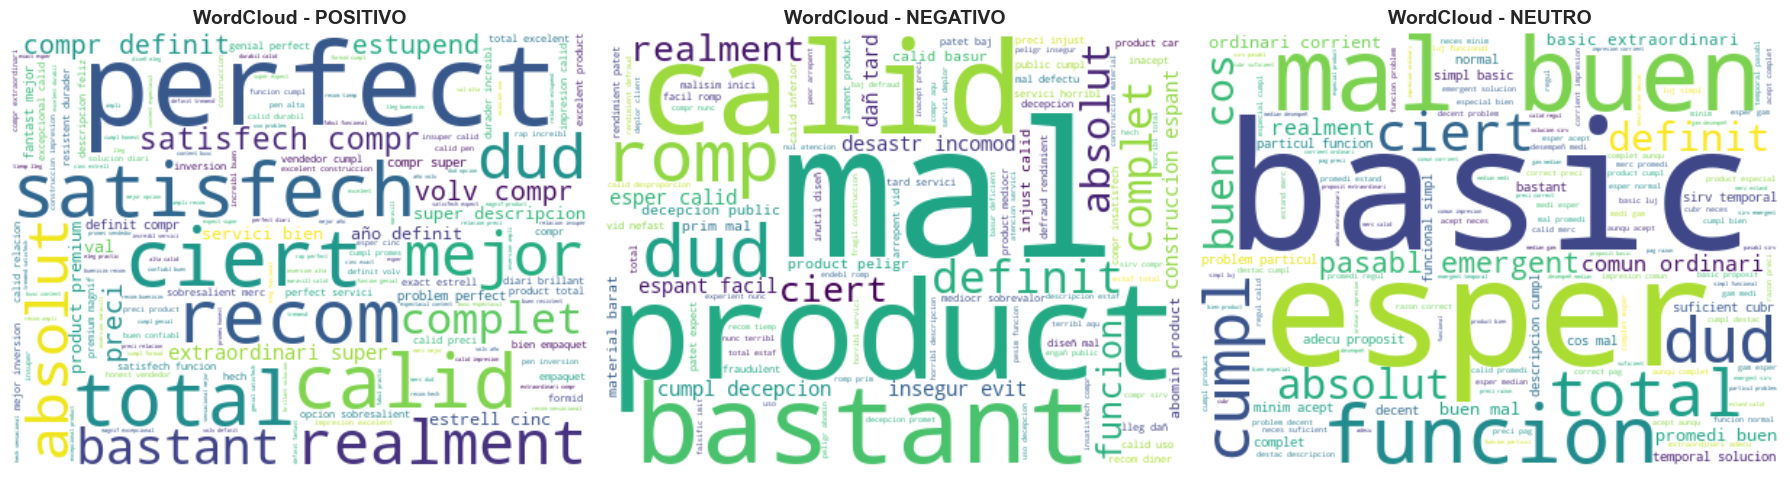

✓ WordClouds guardados

📉 Visualización PCA de TF-IDF...


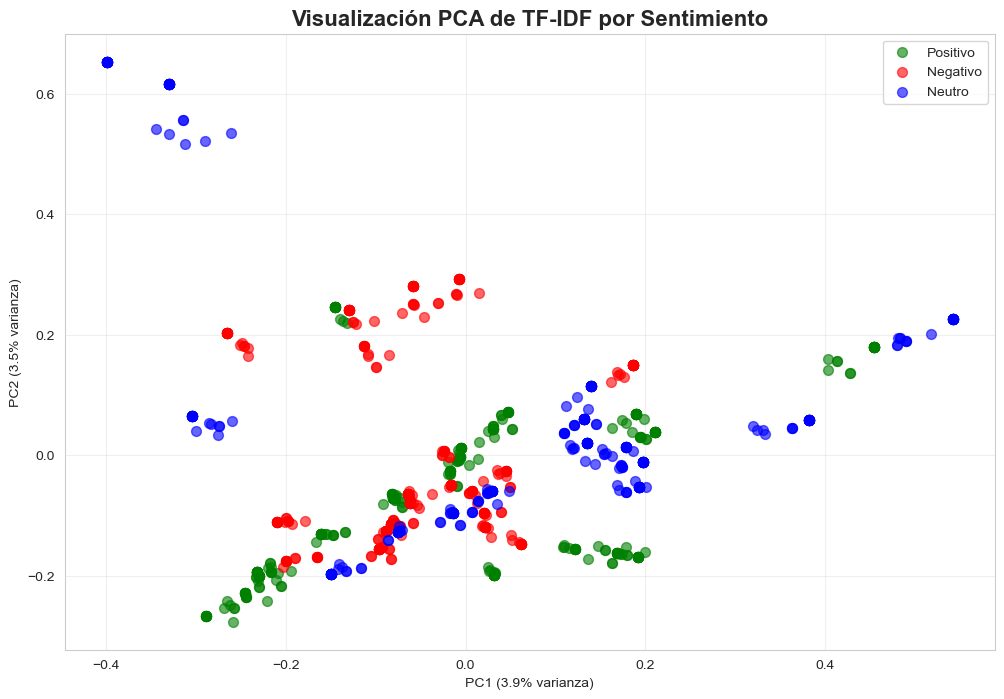

✓ PCA guardado

📉 Visualización t-SNE de Word2Vec...


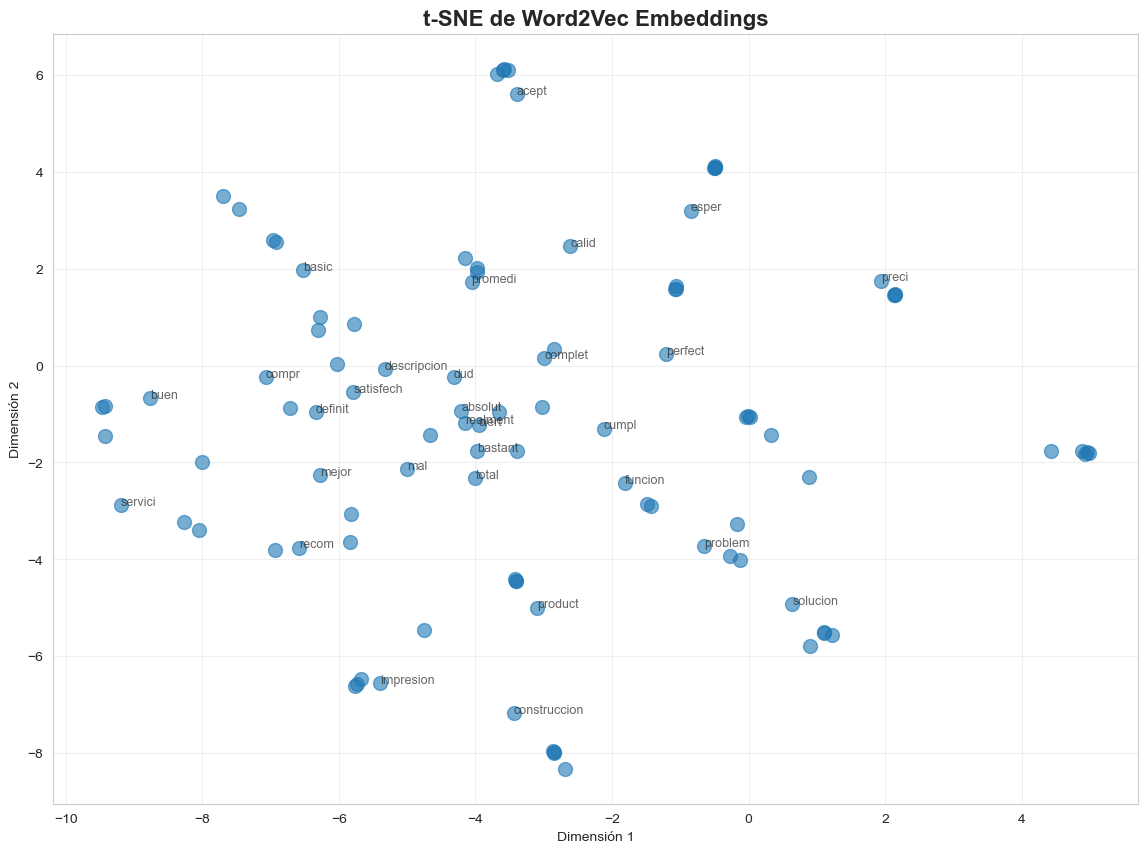

✓ t-SNE guardado


In [36]:
print("\n" + "="*80)
print("VISUALIZACIÓN DE REPRESENTACIONES")
print("="*80)

# 6.1 WordClouds
print("\n☁️  Generando WordClouds...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, sentimiento in enumerate(['positivo', 'negativo', 'neutro']):
    texto_sentimiento = ' '.join(df[df['sentimiento'] == sentimiento]['texto_procesado'])
    wordcloud = WordCloud(width=400, height=300, 
                         background_color='white',
                         colormap='viridis').generate(texto_sentimiento)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'WordCloud - {sentimiento.upper()}', 
                       fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../images/results/wordclouds_sentimientos.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ WordClouds guardados")

# 6.2 PCA de TF-IDF
print("\n📉 Visualización PCA de TF-IDF...")
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray()[:1000])

plt.figure(figsize=(12, 8))
colors = {'positivo': 'green', 'negativo': 'red', 'neutro': 'blue'}
for sentimiento in ['positivo', 'negativo', 'neutro']:
    mask = df[:1000]['sentimiento'] == sentimiento
    plt.scatter(tfidf_pca[mask, 0], tfidf_pca[mask, 1], 
                label=sentimiento.capitalize(), 
                alpha=0.6, s=50, c=colors[sentimiento])

plt.title('Visualización PCA de TF-IDF por Sentimiento', 
         fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('../images/results/pca_tfidf.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ PCA guardado")

# 6.3 t-SNE de embeddings
print("\n📉 Visualización t-SNE de Word2Vec...")
palabras_frecuentes = [word for word, count in 
                      Counter([t for tokens in df['tokens'] for t in tokens]).most_common(100) 
                      if word in w2v_model.wv]

embeddings = np.array([w2v_model.wv[word] for word in palabras_frecuentes])
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(palabras_frecuentes)-1))
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=100)
for i, palabra in enumerate(palabras_frecuentes[:30]):
    plt.annotate(palabra, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                fontsize=9, alpha=0.7)
plt.title('t-SNE de Word2Vec Embeddings', fontsize=16, fontweight='bold')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid(alpha=0.3)
plt.savefig('../images/results/tsne_word2vec.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ t-SNE guardado")

# ============================================================================
# 7. MODELOS PROBABILÍSTICOS - N-GRAMAS
# ============================================================================


FASE 3: MODELOS PROBABILÍSTICOS (N-GRAMAS)

🔢 Entrenando modelos N-gramas...

  Modelo 2-grama...
    Entropía: 5.3706
    Perplejidad: 41.3711

  Modelo 3-grama...
    Entropía: 5.3706
    Perplejidad: 41.3711

  Modelo 3-grama...
    Entropía: 6.0346
    Perplejidad: 65.5529

  Modelo 4-grama...
    Entropía: 6.0346
    Perplejidad: 65.5529

  Modelo 4-grama...
    Entropía: 6.2891
    Perplejidad: 78.1996

📊 RESUMEN DE MODELOS N-GRAMAS:
 n  perplexity  entropy
 2   41.371112 5.370552
 3   65.552863 6.034587
 4   78.199571 6.289089
    Entropía: 6.2891
    Perplejidad: 78.1996

📊 RESUMEN DE MODELOS N-GRAMAS:
 n  perplexity  entropy
 2   41.371112 5.370552
 3   65.552863 6.034587
 4   78.199571 6.289089


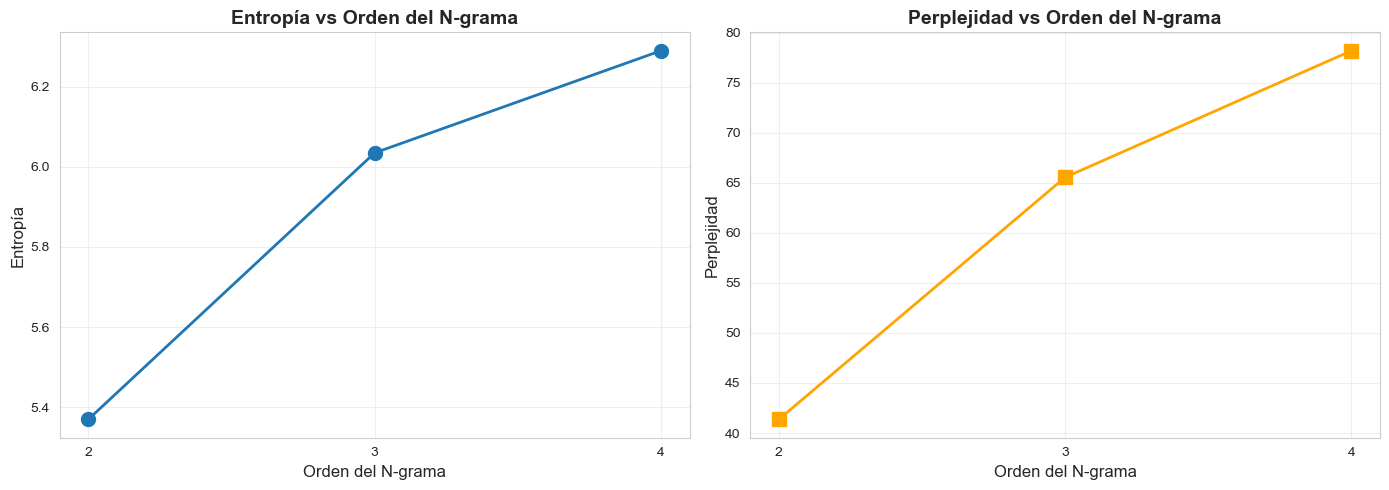


✓ Gráficas guardadas


In [37]:
print("\n" + "="*80)
print("FASE 3: MODELOS PROBABILÍSTICOS (N-GRAMAS)")
print("="*80)

class NGramModel:
    def __init__(self, n=2):
        self.n = n
        self.ngrams = defaultdict(Counter)
        self.context_counts = Counter()
        
    def train(self, tokens_list):
        """Entrena el modelo con los tokens"""
        for tokens in tokens_list:
            # Agregar símbolos de inicio y fin
            padded = ['<START>'] * (self.n - 1) + tokens + ['<END>']
            
            for i in range(len(padded) - self.n + 1):
                context = tuple(padded[i:i+self.n-1])
                word = padded[i+self.n-1]
                self.ngrams[context][word] += 1
                self.context_counts[context] += 1
    
    def probability(self, context, word, smoothing='laplace', alpha=1.0):
        """Calcula probabilidad con smoothing"""
        context = tuple(context)
        vocab_size = len(set([w for counter in self.ngrams.values() for w in counter]))
        
        if smoothing == 'laplace':
            count = self.ngrams[context][word]
            context_count = self.context_counts[context]
            return (count + alpha) / (context_count + alpha * vocab_size)
        else:
            count = self.ngrams[context][word]
            context_count = self.context_counts[context]
            return count / context_count if context_count > 0 else 0
    
    def calculate_perplexity(self, test_tokens_list):
        """Calcula perplejidad"""
        log_prob_sum = 0
        word_count = 0
        
        for tokens in test_tokens_list:
            padded = ['<START>'] * (self.n - 1) + tokens + ['<END>']
            
            for i in range(len(padded) - self.n + 1):
                context = padded[i:i+self.n-1]
                word = padded[i+self.n-1]
                
                prob = self.probability(context, word)
                if prob > 0:
                    log_prob_sum += np.log2(prob)
                    word_count += 1
        
        entropy = -log_prob_sum / word_count if word_count > 0 else float('inf')
        perplexity = 2 ** entropy
        
        return perplexity, entropy

# Dividir datos
train_tokens, test_tokens = train_test_split(df['tokens'].tolist(), 
                                             test_size=0.2, random_state=42)

# Entrenar modelos
resultados_ngramas = []
print("\n🔢 Entrenando modelos N-gramas...")

for n in [2, 3, 4]:
    print(f"\n  Modelo {n}-grama...")
    model = NGramModel(n=n)
    model.train(train_tokens)
    
    perplexity, entropy = model.calculate_perplexity(test_tokens[:100])
    resultados_ngramas.append({
        'n': n,
        'perplexity': perplexity,
        'entropy': entropy
    })
    
    print(f"    Entropía: {entropy:.4f}")
    print(f"    Perplejidad: {perplexity:.4f}")

# Visualizar resultados
df_ngramas = pd.DataFrame(resultados_ngramas)
print("\n📊 RESUMEN DE MODELOS N-GRAMAS:")
print(df_ngramas.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(df_ngramas['n'], df_ngramas['entropy'], marker='o', linewidth=2, markersize=10)
ax1.set_xlabel('Orden del N-grama', fontsize=12)
ax1.set_ylabel('Entropía', fontsize=12)
ax1.set_title('Entropía vs Orden del N-grama', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.set_xticks([2, 3, 4])

ax2.plot(df_ngramas['n'], df_ngramas['perplexity'], marker='s', 
         linewidth=2, markersize=10, color='orange')
ax2.set_xlabel('Orden del N-grama', fontsize=12)
ax2.set_ylabel('Perplejidad', fontsize=12)
ax2.set_title('Perplejidad vs Orden del N-grama', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.set_xticks([2, 3, 4])

plt.tight_layout()
plt.savefig('../images/models/ngramas_metricas.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Gráficas guardadas")

# ============================================================================
# 8. CLASIFICACIÓN SUPERVISADA
# ============================================================================

In [38]:
print("\n" + "="*80)
print("FASE 4: CLASIFICACIÓN SUPERVISADA")
print("="*80)

# Preparar datos
X = tfidf_matrix
y = df['sentimiento']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 Datos de entrenamiento: {X_train.shape[0]}")
print(f"📊 Datos de prueba: {X_test.shape[0]}")


FASE 4: CLASIFICACIÓN SUPERVISADA

📊 Datos de entrenamiento: 2404
📊 Datos de prueba: 601



🤖 Entrenando Naive Bayes...

📊 RESULTADOS NAIVE BAYES:
Accuracy: 1.0000
F1-Score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00       200
      neutro       1.00      1.00      1.00       201
    positivo       1.00      1.00      1.00       200

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



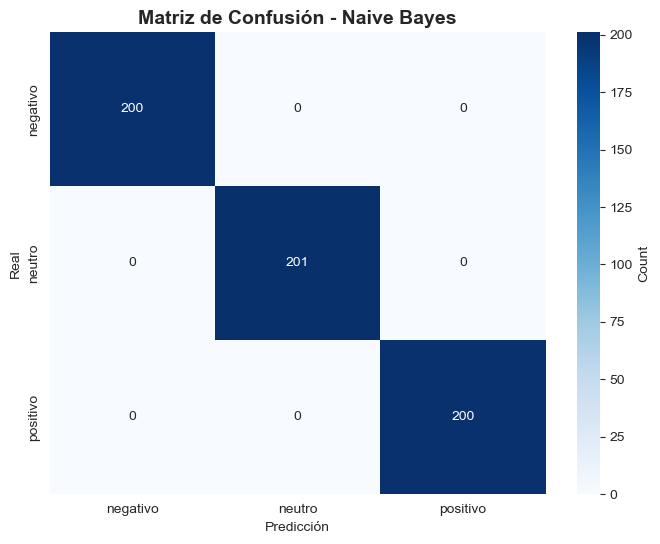

✓ Matriz guardada


In [39]:
# ============================================================================
# 8.1 MODELO 1: NAIVE BAYES
# ============================================================================

print("\n🤖 Entrenando Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("\n📊 RESULTADOS NAIVE BAYES:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_nb, average='macro'):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

# Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, cbar_kws={'label': 'Count'})
plt.title('Matriz de Confusión - Naive Bayes', fontsize=14, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.savefig('../images/models/confusion_matrix_nb.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Matriz guardada")


🤖 Entrenando SVM...

📊 RESULTADOS SVM:
Accuracy: 1.0000
F1-Score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00       200
      neutro       1.00      1.00      1.00       201
    positivo       1.00      1.00      1.00       200

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



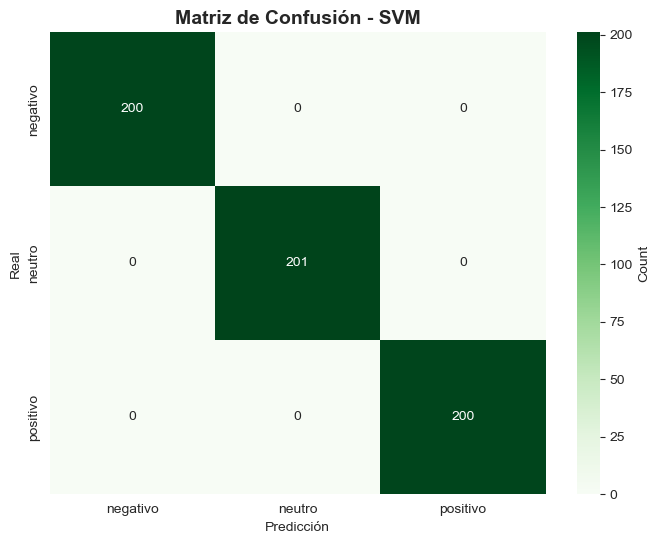

✓ Matriz guardada


In [40]:
# ============================================================================
# 8.2 MODELO 2: SVM
# ============================================================================

print("\n🤖 Entrenando SVM...")
svm_model = LinearSVC(random_state=42, max_iter=2000)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("\n📊 RESULTADOS SVM:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_svm, average='macro'):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_, cbar_kws={'label': 'Count'})
plt.title('Matriz de Confusión - SVM', fontsize=14, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.savefig('../images/models/confusion_matrix_svm.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Matriz guardada")




🤖 Entrenando Regresión Logística...

📊 RESULTADOS REGRESIÓN LOGÍSTICA:
Accuracy: 1.0000
F1-Score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00       200
      neutro       1.00      1.00      1.00       201
    positivo       1.00      1.00      1.00       200

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601

              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00       200
      neutro       1.00      1.00      1.00       201
    positivo       1.00      1.00      1.00       200

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



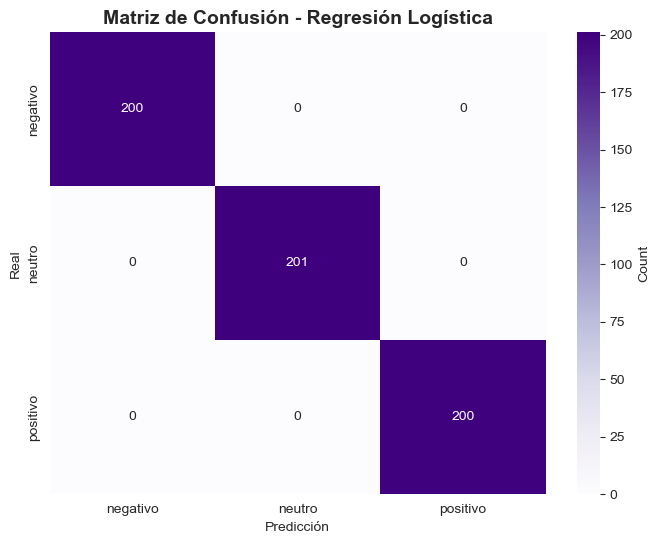

✓ Matriz guardada


In [41]:
# ============================================================================
# 8.3 LOGISTIC REGRESSION (ALTERNATIVA A CNN)
# ============================================================================

print("\n🤖 Entrenando Regresión Logística...")
lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("\n📊 RESULTADOS REGRESIÓN LOGÍSTICA:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_lr, average='macro'):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', 
            xticklabels=le.classes_, yticklabels=le.classes_, cbar_kws={'label': 'Count'})
plt.title('Matriz de Confusión - Regresión Logística', fontsize=14, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.savefig('../images/models/confusion_matrix_lr.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Matriz guardada")


🤖 Entrenando Random Forest...

📊 RESULTADOS RANDOM FOREST:
Accuracy: 1.0000
F1-Score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00       200
      neutro       1.00      1.00      1.00       201
    positivo       1.00      1.00      1.00       200

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601


📊 RESULTADOS RANDOM FOREST:
Accuracy: 1.0000
F1-Score (macro): 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00       200
      neutro       1.00      1.00      1.00       201
    positivo       1.00      1.00      1.00       200

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



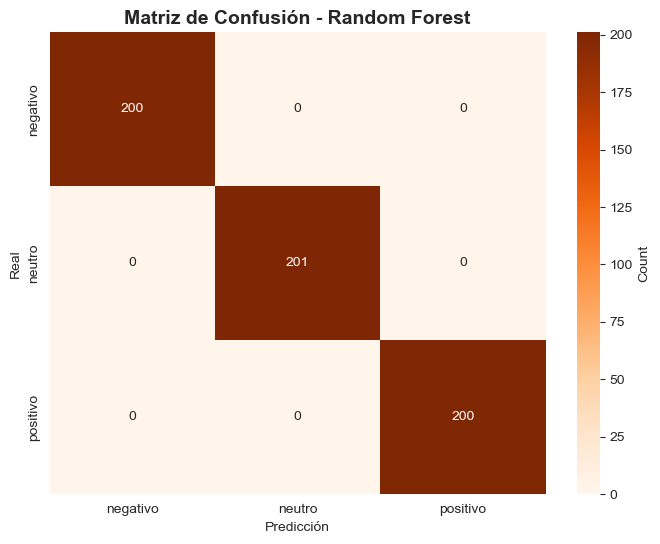

✓ Matriz guardada


In [42]:
# ============================================================================
# 8.4 RANDOM FOREST
# ============================================================================

print("\n🤖 Entrenando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n📊 RESULTADOS RANDOM FOREST:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, yticklabels=le.classes_, cbar_kws={'label': 'Count'})
plt.title('Matriz de Confusión - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.savefig('../images/models/confusion_matrix_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Matriz guardada")

# ============================================================================
# 9. COMPARACIÓN DE MODELOS
# ============================================================================


COMPARACIÓN FINAL DE MODELOS

📊 TABLA COMPARATIVA DE MODELOS:
             Modelo  Accuracy  F1-Score
        Naive Bayes       1.0       1.0
                SVM       1.0       1.0
Regresión Logística       1.0       1.0
      Random Forest       1.0       1.0


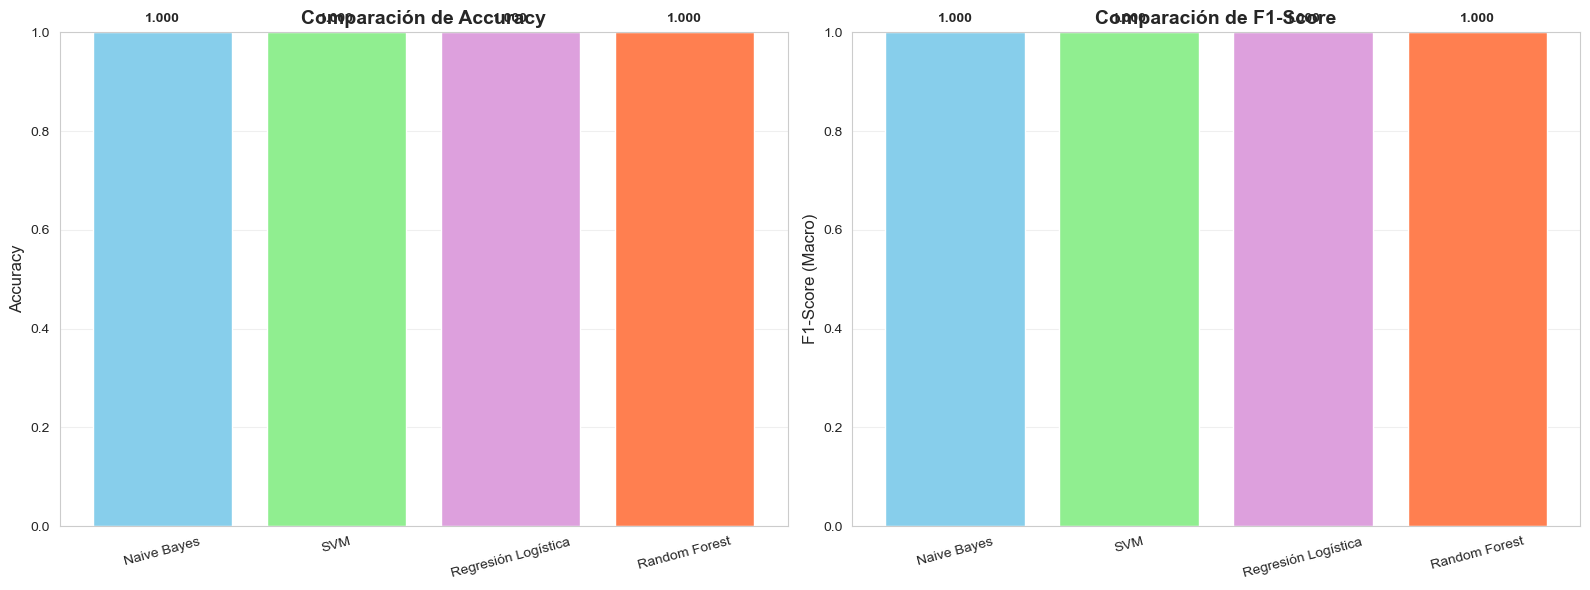


✓ Gráfica comparativa guardada

🏆 MEJOR MODELO: Naive Bayes
   Accuracy: 1.0000
   F1-Score: 1.0000


In [43]:
print("\n" + "="*80)
print("COMPARACIÓN FINAL DE MODELOS")
print("="*80)

# Tabla comparativa
resultados_modelos = pd.DataFrame({
    'Modelo': ['Naive Bayes', 'SVM', 'Regresión Logística', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_nb, average='macro'),
        f1_score(y_test, y_pred_svm, average='macro'),
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro')
    ]
})

print("\n📊 TABLA COMPARATIVA DE MODELOS:")
print(resultados_modelos.to_string(index=False))

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
colors_bar = ['skyblue', 'lightgreen', 'plum', 'coral']
ax1.bar(resultados_modelos['Modelo'], resultados_modelos['Accuracy'], color=colors_bar)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Comparación de Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=15)
for i, v in enumerate(resultados_modelos['Accuracy']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score
ax2.bar(resultados_modelos['Modelo'], resultados_modelos['F1-Score'], color=colors_bar)
ax2.set_ylabel('F1-Score (Macro)', fontsize=12)
ax2.set_title('Comparación de F1-Score', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=15)
for i, v in enumerate(resultados_modelos['F1-Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../images/results/comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Gráfica comparativa guardada")

# Mejor modelo
mejor_idx = resultados_modelos['F1-Score'].idxmax()
mejor_modelo = resultados_modelos.iloc[mejor_idx]
print(f"\n🏆 MEJOR MODELO: {mejor_modelo['Modelo']}")
print(f"   Accuracy: {mejor_modelo['Accuracy']:.4f}")
print(f"   F1-Score: {mejor_modelo['F1-Score']:.4f}")


# ============================================================================
# 10. ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES
# ============================================================================


ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES


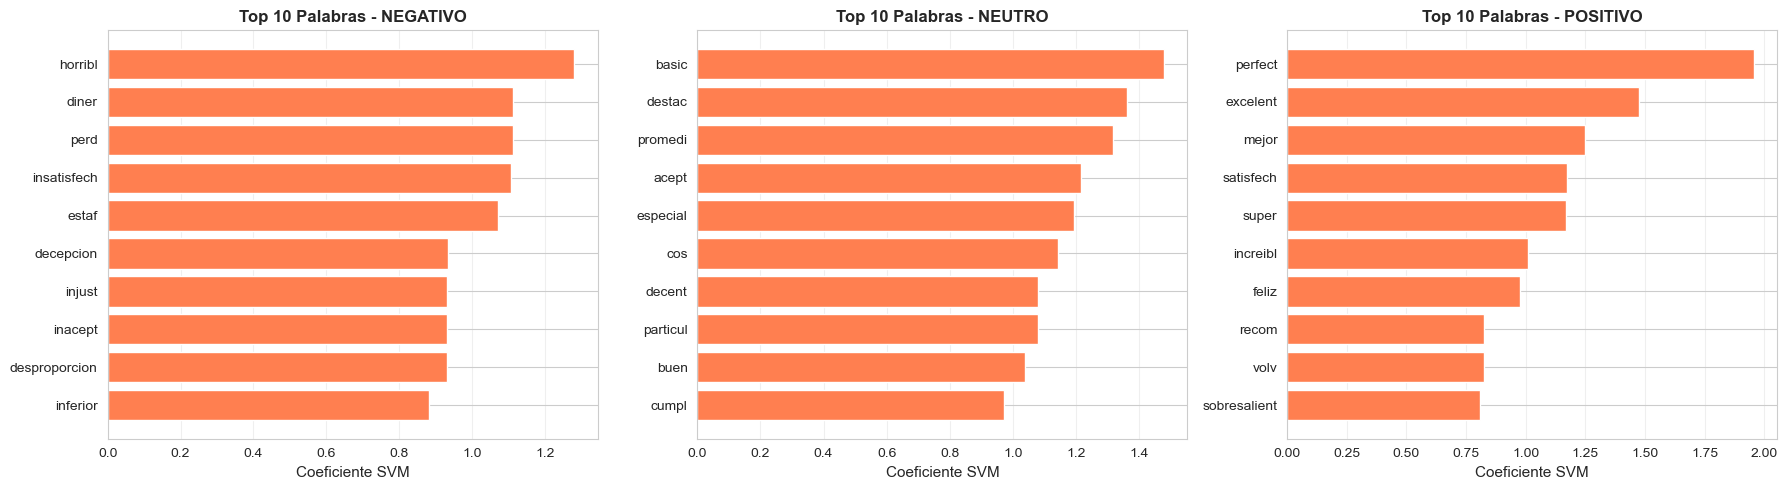

✓ Análisis de características guardado


In [44]:
print("\n" + "="*80)
print("ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES")
print("="*80)

# Obtener palabras más importantes (usando SVM)
feature_names = vectorizer_tfidf.get_feature_names_out()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (clase, nombre_clase) in enumerate(zip([0, 1, 2], le.classes_)):
    coef = svm_model.coef_[idx]
    top_indices = np.argsort(coef)[-10:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = coef[top_indices]
    
    axes[idx].barh(range(len(top_features)), top_scores, color='coral')
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features)
    axes[idx].set_xlabel('Coeficiente SVM', fontsize=11)
    axes[idx].set_title(f'Top 10 Palabras - {nombre_clase.upper()}', 
                       fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/palabras_importantes.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Análisis de características guardado")

# ============================================================================
# 11. VALIDACIÓN CRUZADA
# ============================================================================


VALIDACIÓN CRUZADA

🔄 Realizando validación cruzada (5-fold)...
Naive Bayes          - F1 Macro: 1.0000 (+/- 0.0000)
SVM                  - F1 Macro: 1.0000 (+/- 0.0000)
Regresión Logística  - F1 Macro: 1.0000 (+/- 0.0000)
Random Forest        - F1 Macro: 1.0000 (+/- 0.0000)


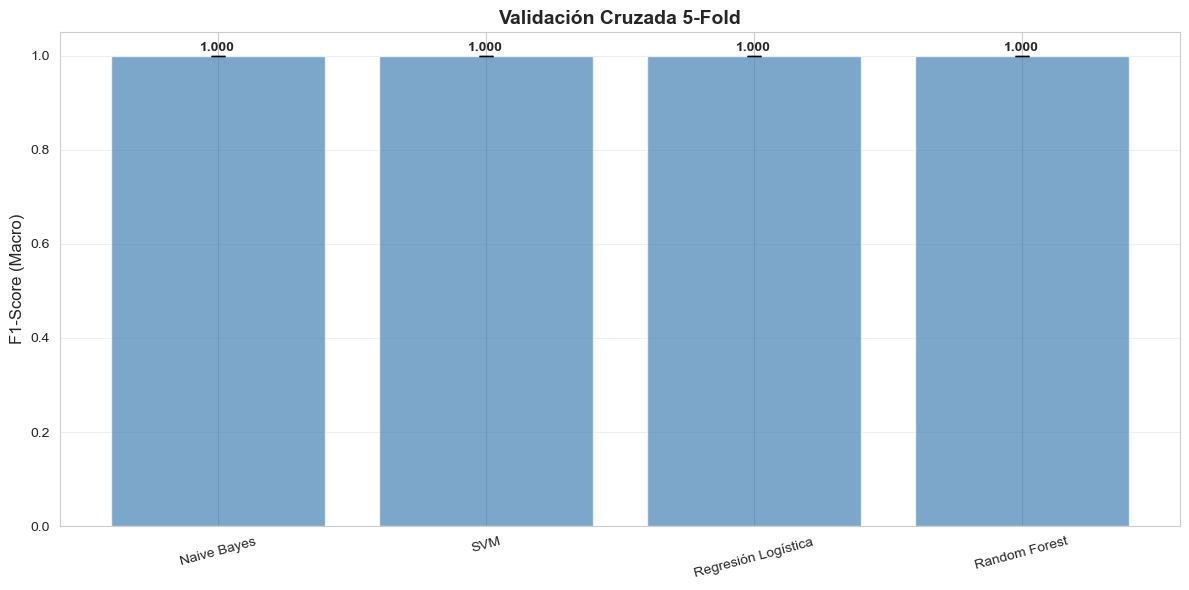


✓ Validación cruzada completada


In [46]:
print("\n" + "="*80)
print("VALIDACIÓN CRUZADA")
print("="*80)

print("\n🔄 Realizando validación cruzada (5-fold)...")

modelos_cv = {
    'Naive Bayes': nb_model,
    'SVM': svm_model,
    'Regresión Logística': lr_model,
    'Random Forest': rf_model
}

resultados_cv = []

for nombre, modelo in modelos_cv.items():
    scores = cross_val_score(modelo, X, y_encoded, cv=5, scoring='f1_macro')
    resultados_cv.append({
        'Modelo': nombre,
        'Media': scores.mean(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max()
    })
    print(f"{nombre:20s} - F1 Macro: {scores.mean():.4f} (+/- {scores.std():.4f})")

df_cv = pd.DataFrame(resultados_cv)

# Visualización
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(df_cv))
plt.bar(x_pos, df_cv['Media'], yerr=df_cv['Std'], capsize=5, alpha=0.7, color='steelblue')
plt.xticks(x_pos, df_cv['Modelo'], rotation=15)
plt.ylabel('F1-Score (Macro)', fontsize=12)
plt.title('Validación Cruzada 5-Fold', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(df_cv['Media']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../images/results/validacion_cruzada.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Validación cruzada completada")

# ============================================================================
# 12. SISTEMA DE PREDICCIÓN
# ============================================================================

In [ ]:
print("\n" + "="*80)
print("SISTEMA DE PREDICCIÓN EN TIEMPO REAL")
print("="*80)

def predecir_sentimiento(texto_nuevo):
    """
    Predice el sentimiento de un texto nuevo usando todos los modelos
    """
    # Preprocesar
    tokens = preprocesar_texto(texto_nuevo)
    texto_proc = ' '.join(tokens)
    
    # Transformar con TF-IDF
    texto_tfidf = vectorizer_tfidf.transform([texto_proc])
    
    # Predicciones
    pred_nb = le.inverse_transform([nb_model.predict(texto_tfidf)[0]])[0]
    pred_svm = le.inverse_transform([svm_model.predict(texto_tfidf)[0]])[0]
    pred_lr = le.inverse_transform([lr_model.predict(texto_tfidf)[0]])[0]
    pred_rf = le.inverse_transform([rf_model.predict(texto_tfidf)[0]])[0]
    
    # Probabilidades (usando LR)
    probabilidades = lr_model.predict_proba(texto_tfidf)[0]
    prob_dict = dict(zip(le.classes_, probabilidades))
    
    return {
        'texto_original': texto_nuevo,
        'texto_procesado': texto_proc,
        'naive_bayes': pred_nb,
        'svm': pred_svm,
        'regresion_logistica': pred_lr,
        'random_forest': pred_rf,
        'probabilidades': prob_dict
    }

# Ejemplos de predicción
textos_prueba = [
    "Este producto es absolutamente fantástico, lo recomiendo totalmente",
    "Muy decepcionado con la compra, no funciona bien para nada",
    "El producto está bien, nada especial pero cumple su función",
    "Excelente calidad precio, superó mis expectativas completamente",
    "Pésima experiencia, llegó roto y el servicio es horrible"
]

print("\n🔮 EJEMPLOS DE PREDICCIÓN:\n")
for i, texto in enumerate(textos_prueba, 1):
    resultado = predecir_sentimiento(texto)
    print(f"{'='*70}")
    print(f"Texto {i}: {texto}")
    print(f"{'='*70}")
    print(f"  Tokens procesados: {resultado['texto_procesado'][:60]}...")
    print(f"\n  PREDICCIONES:")
    print(f"    → Naive Bayes:        {resultado['naive_bayes']}")
    print(f"    → SVM:                {resultado['svm']}")
    print(f"    → Regresión Logística: {resultado['regresion_logistica']}")
    print(f"    → Random Forest:       {resultado['random_forest']}")
    print(f"\n  PROBABILIDADES:")
    for clase, prob in sorted(resultado['probabilidades'].items(), key=lambda x: -x[1]):
        print(f"    {clase:10s}: {prob:.3f} {'█' * int(prob*50)}")
    print()


SISTEMA DE PREDICCIÓN EN TIEMPO REAL

🔮 EJEMPLOS DE PREDICCIÓN:

Texto 1: Este producto es absolutamente fantástico, lo recomiendo totalmente
  Tokens procesados: product absolut fantast recom total...

  PREDICCIONES:
    → Naive Bayes:        positivo
    → SVM:                positivo
    → Regresión Logística: positivo
    → Random Forest:       negativo

  PROBABILIDADES:
    positivo  : 0.656 ████████████████████████████████
    negativo  : 0.255 ████████████
    neutro    : 0.088 ████

Texto 2: Muy decepcionado con la compra, no funciona bien para nada
  Tokens procesados: decepcion compr funcion bien...

  PREDICCIONES:
    → Naive Bayes:        negativo
    → SVM:                negativo
    → Regresión Logística: negativo
    → Random Forest:       negativo

  PROBABILIDADES:
    negativo  : 0.697 ██████████████████████████████████
    positivo  : 0.158 ███████
    neutro    : 0.145 ███████

Texto 3: El producto está bien, nada especial pero cumple su función
  Tokens proces

# ============================================================================
# 13. EXPORTAR MODELOS Y RESULTADOS
# ============================================================================

In [ ]:
print("\n" + "="*80)
print("EXPORTANDO MODELOS Y RESULTADOS")
print("="*80)

import pickle
import os

# Crear directorios si no existen
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Guardar modelos
print("\n💾 Guardando modelos...")
with open('models/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

with open('models/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('models/vectorizer_tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer_tfidf, f)

with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

with open('models/word2vec_model.pkl', 'wb') as f:
    pickle.dump(w2v_model, f)

print("✓ Modelos guardados en carpeta 'models/'")

# Crear reporte completo
print("\n📄 Generando reporte JSON...")
reporte = {
    'metadata': {
        'fecha': '2025-10-06',
        'total_documentos': len(df),
        'vocabulario_size': len(vocabulario),
        'clases': list(le.classes_)
    },
    'distribucion_clases': df['sentimiento'].value_counts().to_dict(),
    'estadisticas_corpus': {
        'longitud_promedio_tokens': float(df['tokens'].apply(len).mean()),
        'longitud_maxima': int(df['tokens'].apply(len).max()),
        'longitud_minima': int(df['tokens'].apply(len).min())
    },
    'representaciones': {
        'bow_dimension': list(bow_matrix.shape),
        'tfidf_dimension': list(tfidf_matrix.shape),
        'coocurrencia_dimension': list(cooc_matrix.shape),
        'word2vec_vocab': len(w2v_model.wv),
        'pca_varianza_explicada': [float(pca.explained_variance_ratio_[0]), 
                                   float(pca.explained_variance_ratio_[1])]
    },
    'ngramas': df_ngramas.to_dict('records'),
    'modelos': {
        'resultados': resultados_modelos.to_dict('records'),
        'validacion_cruzada': df_cv.to_dict('records')
    },
    'mejor_modelo': {
        'nombre': mejor_modelo['Modelo'],
        'accuracy': float(mejor_modelo['Accuracy']),
        'f1_score': float(mejor_modelo['F1-Score'])
    }
}

import json
with open('results/reporte_completo.json', 'w', encoding='utf-8') as f:
    json.dump(reporte, f, indent=2, ensure_ascii=False)

print("✓ Reporte JSON guardado en 'results/reporte_completo.json'")

# Exportar predicciones
print("\n📊 Exportando predicciones...")
df_resultados = df.copy()
df_resultados['prediccion_svm'] = svm_model.predict(X)
df_resultados['prediccion_svm'] = le.inverse_transform(df_resultados['prediccion_svm'])
df_resultados['prediccion_nb'] = nb_model.predict(X)
df_resultados['prediccion_nb'] = le.inverse_transform(df_resultados['prediccion_nb'])
df_resultados.to_csv('results/predicciones.csv', index=False, encoding='utf-8')
print("✓ Predicciones guardadas en 'results/predicciones.csv'")

# Exportar métricas detalladas
print("\n📈 Exportando métricas detalladas...")
metricas_detalladas = {
    'Naive Bayes': classification_report(y_test, y_pred_nb, target_names=le.classes_, output_dict=True),
    'SVM': classification_report(y_test, y_pred_svm, target_names=le.classes_, output_dict=True),
    'Regresión Logística': classification_report(y_test, y_pred_lr, target_names=le.classes_, output_dict=True),
    'Random Forest': classification_report(y_test, y_pred_rf, target_names=le.classes_, output_dict=True)
}

with open('results/metricas_detalladas.json', 'w', encoding='utf-8') as f:
    json.dump(metricas_detalladas, f, indent=2, ensure_ascii=False)
print("✓ Métricas detalladas guardadas")


EXPORTANDO MODELOS Y RESULTADOS

💾 Guardando modelos...
✓ Modelos guardados en carpeta 'models/'

📄 Generando reporte JSON...
✓ Reporte JSON guardado en 'results/reporte_completo.json'

📊 Exportando predicciones...
✓ Predicciones guardadas en 'results/predicciones.csv'

📈 Exportando métricas detalladas...
✓ Métricas detalladas guardadas
